In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms
from PIL import ImageFile
from collections import Counter
from transformers import ViTForImageClassification
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
DATA_DIR = "/kaggle/input/14-classes-dataset/filtered_dataset"
BATCH_SIZE = 32
NUM_CLASSES = 14
EPOCHS = 5

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [8]:
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

In [9]:
train_targets = [full_dataset.targets[i] for i in train_dataset.indices]
class_counts = Counter(train_targets)
total_samples = sum(class_counts.values())
class_weights = [total_samples / (NUM_CLASSES * class_counts.get(i, 1)) for i in range(NUM_CLASSES)]
sample_weights = [class_weights[label] for label in train_targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [43]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=NUM_CLASSES
)
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [44]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))

In [46]:
def train(epochs, train_loader, optimizer, model, criterion, device):
    model.train()
    for epoch in range(epochs):
        epoch_starting_time = time.time()
        print(f"Epoch # {epoch + 1}/{epochs}\n")
        epoch_loss = 0
        
        for batch_number, (batch_inputs, batch_labels) in enumerate(train_loader):
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_inputs)

            loss = criterion(outputs.logits, batch_labels)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

            if (batch_number + 1) % 100 == 0:
                print(f"batch number: {batch_number + 1}/{len(train_loader)}, Loss: {loss.item():.3f}")

        print(f"\nAverage training loss of epoch # {epoch + 1}: {epoch_loss / len(train_loader):.3f}")
        epoch_duration = time.time() - epoch_starting_time

        epoch_duration_minutes = epoch_duration // 60

        epoch_duration_seconds = epoch_duration - (epoch_duration_minutes * 60)
        
        print(f"Epoch # {epoch + 1} took {epoch_duration_minutes} minutes and {epoch_duration_seconds:.3f} seconds\n")

In [47]:
train(EPOCHS, train_loader, optimizer, model, criterion, device)

Epoch # 1/5

batch number: 100/945, Loss: 2.251
batch number: 200/945, Loss: 1.857
batch number: 300/945, Loss: 1.487
batch number: 400/945, Loss: 1.132
batch number: 500/945, Loss: 1.144
batch number: 600/945, Loss: 0.790
batch number: 700/945, Loss: 0.717
batch number: 800/945, Loss: 0.703
batch number: 900/945, Loss: 0.728

Average training loss of epoch # 1: 1.289
Epoch # 1 took 9.0 minutes and 19.480 seconds

Epoch # 2/5

batch number: 100/945, Loss: 0.882
batch number: 200/945, Loss: 0.757
batch number: 300/945, Loss: 0.485
batch number: 400/945, Loss: 0.682
batch number: 500/945, Loss: 0.384
batch number: 600/945, Loss: 0.429
batch number: 700/945, Loss: 0.856
batch number: 800/945, Loss: 0.392
batch number: 900/945, Loss: 0.632

Average training loss of epoch # 2: 0.608
Epoch # 2 took 9.0 minutes and 20.039 seconds

Epoch # 3/5

batch number: 100/945, Loss: 0.301
batch number: 200/945, Loss: 0.575
batch number: 300/945, Loss: 0.341
batch number: 400/945, Loss: 0.380
batch numbe

In [48]:
def evaluate_and_report(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for inputs_batch, labels_batch in data_loader:
            inputs_batch = inputs_batch.to(device)
            labels_batch = labels_batch.to(device)

            outputs = model(inputs_batch)
            loss = criterion(outputs.logits, labels_batch)
            total_loss += loss.item()

            _, predictions = torch.max(outputs.logits, dim=1)
            predicted_labels.extend(predictions.cpu().numpy())
            true_labels.extend(labels_batch.cpu().numpy())

    average_loss_test = total_loss / len(data_loader)
    accuracy = (torch.tensor(predicted_labels) == torch.tensor(true_labels)).sum().item() / len(true_labels)

    return average_loss_test, accuracy, predicted_labels, true_labels

In [49]:
average_loss_test, accuracy, predicted_labels, true_labels = evaluate_and_report(model, val_loader, criterion, device)

In [50]:
average_loss_test

0.6884155092494828

In [51]:
accuracy

0.8023809523809524

In [52]:
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       260
           1       0.85      0.64      0.73       277
           2       0.92      0.87      0.89       259
           3       0.99      0.99      0.99       278
           4       0.87      0.84      0.86       283
           5       0.66      0.75      0.70       265
           6       0.71      0.87      0.78       287
           7       0.77      0.62      0.69       286
           8       0.72      0.72      0.72       239
           9       0.87      0.83      0.85       286
          10       0.60      0.78      0.67       247
          11       0.81      0.96      0.88       269
          12       0.92      0.89      0.91       275
          13       0.75      0.72      0.74       269

    accuracy                           0.80      3780
   macro avg       0.81      0.80      0.80      3780
weighted avg       0.81      0.80      0.80      3780



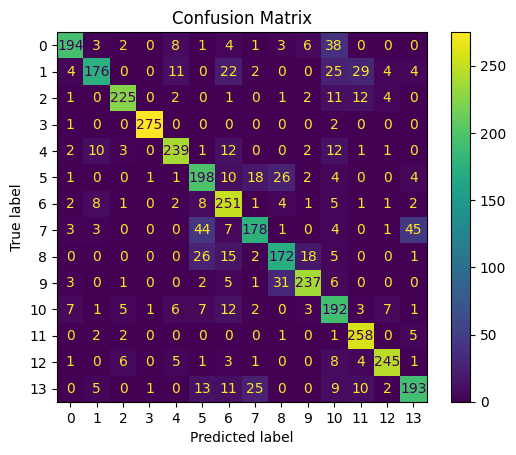

In [53]:
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [54]:
torch.save(model.state_dict(), "ViT_bone_marrow_classifier.pth")

In [ ]:
# model = ViTForImageClassification.from_pretrained(
#     "google/vit-base-patch16-224-in21k",
#     num_labels=14
# )

# model.load_state_dict(torch.load("ViT_bone_marrow_classifier.pth"))
# model.to(device)
# model.eval()